In [1]:
# !pip install pdf2image
# pdf2image 라이브러리 임포트
from pdf2image import convert_from_path

In [2]:
FILE_NAME = "Z:/5_AI/HDAT/BSJ/실습/240412/슬기로운용어사전.pdf"
print(FILE_NAME)

Z:/5_AI/HDAT/BSJ/실습/240412/슬기로운용어사전.pdf


In [3]:
# !apt-get install -y poppler-utils
# conda install -c conda-forge poppler

In [4]:
# `convert_from_path` 함수 통해 PDF 파일 읽어와 이미지 리스트로 변환
images = convert_from_path(FILE_NAME)

In [5]:
len(images)

9

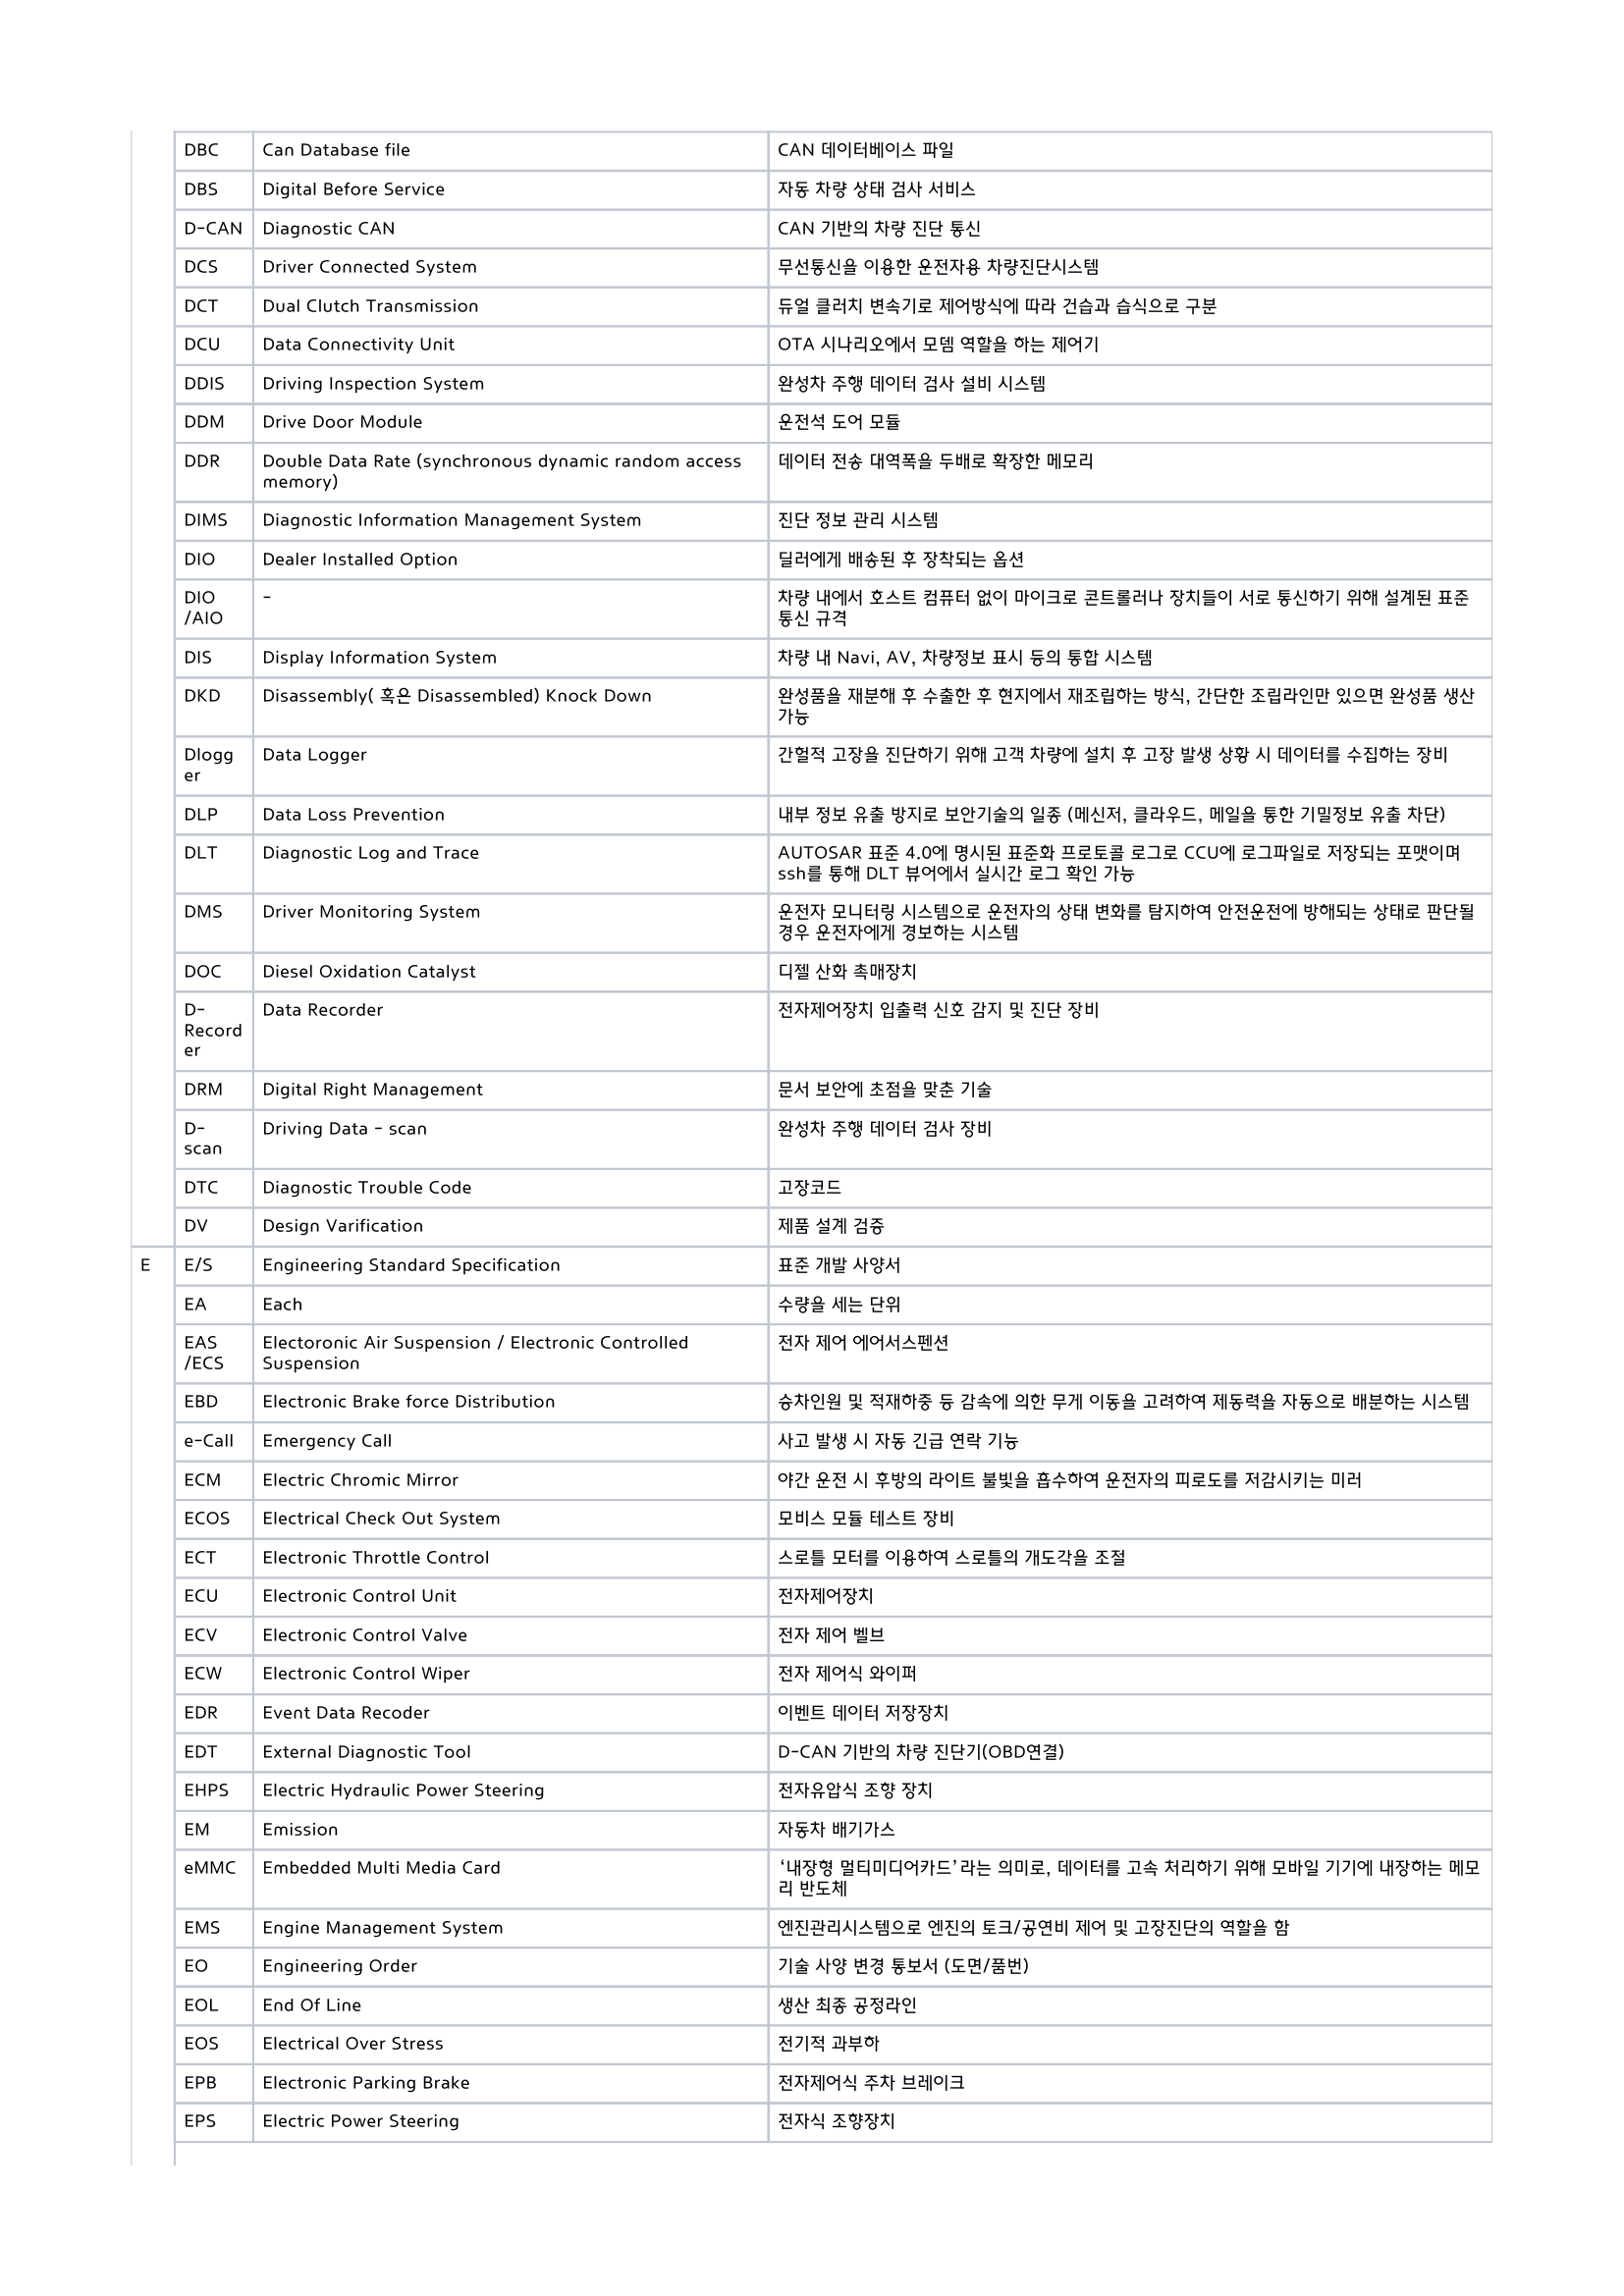

In [6]:
# 변환된 이미지 확인
images[2]

In [7]:
# 다음 단계를 위해 이미지 파일 로컬에 저장
jpgs = []
for i, image in enumerate(images):
    print(f"page_{str(i+1)}.jpg")
    image.save(f"page_{str(i+1)}.jpg", "JPEG")
    jpgs.append(f"page_{str(i+1)}.jpg")

page_1.jpg
page_2.jpg
page_3.jpg
page_4.jpg
page_5.jpg
page_6.jpg
page_7.jpg
page_8.jpg
page_9.jpg


## Azure Computer Vision

In [ ]:
# !pip install opencv-contrib-python
# !pip install azure-cognitiveservices-vision-computervision

##### ENDPOINT_URL 사이트가 보안으로 제한됨

In [8]:
import io
import time
import sys
import numpy as np
import platform
from PIL import ImageFont, ImageDraw, Image
from matplotlib import pyplot as plt

import cv2
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from msrest.authentication import CognitiveServicesCredentials

# Jupyter Notebook 또는 Colab에서 이미지를 확인하기위한 Function
def plt_imshow(title='image', img=None, figsize=(8, 5)):
    # 이미지와 제목을 리스트로 통일
    imgs = [img] if not isinstance(img, list) else img
    titles = [title] * len(imgs) if not isinstance(title, list) else title

    plt.figure(figsize=figsize)  # 그림 크기 설정
    for i, image in enumerate(imgs):  # 이미지 리스트를 반복
        plt.subplot(1, len(imgs), i + 1)  # 서브플롯 배치
        # 이미지가 그레이스케일인지 컬러인지에 따라 적절한 변환 적용
        if image.ndim == 2:  # 그레이스케일 이미지 처리
            plt.imshow(image, cmap='gray')
        else:  # BGR to RGB 변환 후 컬러 이미지 처리
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(titles[i])  # 각 이미지의 제목 설정
        plt.xticks([]), plt.yticks([])  # x, y축 눈금 숨기기

    plt.show()  # 이미지 표시

SUBSCRIPTION_KEY = "90595ad6e26e4062bcc4786c4038c38f"
ENDPOINT_URL = "https://builders-computer-vision.cognitiveservices.azure.com/"

computervision_client = ComputerVisionClient(ENDPOINT_URL, CognitiveServicesCredentials(SUBSCRIPTION_KEY))

In [10]:
# OCR 로 텍스트를 뽑아내는 함수
def detect_text(path):
    print(path)
    imageData = open(path, "rb").read()
    sbuf = io.BytesIO(imageData)

    response = computervision_client.read_in_stream(sbuf, raw=True)
    operationLocation = response.headers["Operation-Location"]
    operationID = operationLocation.split("/")[-1]

    while True:
        read_result = computervision_client.get_read_result(operationID)
        if read_result.status not in ['notStarted', 'running']:
            break
        time.sleep(1)

    if read_result.status == OperationStatusCodes.succeeded:
        img = cv2.imread(path)
        roi_img = img.copy()

        raw_text = ''
        for text_result in read_result.analyze_result.read_results:
            for line in text_result.lines:
                raw_text += line.text
                # --- image 보여지는 코드
        #         box = list(map(int, line.bounding_box))
        #         (tlX, tlY, trX, trY, brX, brY, blX, blY) = box
        #         pts = ((tlX, tlY), (trX, trY), (brX, brY), (blX, blY))

        #         topLeft = pts[0]
        #         topRight = pts[1]
        #         bottomRight = pts[2]
        #         bottomLeft = pts[3]

        #         cv2.line(roi_img, topLeft, topRight, (0,255,0), 2)
        #         cv2.line(roi_img, topRight, bottomRight, (0,255,0), 2)
        #         cv2.line(roi_img, bottomRight, bottomLeft, (0,255,0), 2)
        #         cv2.line(roi_img, bottomLeft, topLeft, (0,255,0), 2)

        # plt_imshow(["Original", "ROI"], [img, roi_img]  , figsize=(16, 10))
        #---
        return raw_text

In [11]:
text = detect_text(jpgs[0])
print(text)

page_1.jpg


ClientRequestError: Error occurred in request., SSLError: HTTPSConnectionPool(host='builders-computer-vision.cognitiveservices.azure.com', port=443): Max retries exceeded with url: /vision/v3.2/read/analyze?model-version=latest&readingOrder=basic (Caused by SSLError(SSLError(1, '[SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:1129)')))

In [29]:
documents = []

for i, jpg in enumerate(jpgs):
    documents.append(
        {
            "page": i+1,
            "text": detect_text(jpg),
        }
    )

print(documents)

page_1.jpg


ClientRequestError: Error occurred in request., SSLError: HTTPSConnectionPool(host='builders-computer-vision.cognitiveservices.azure.com', port=443): Max retries exceeded with url: /vision/v3.2/read/analyze?model-version=latest&readingOrder=basic (Caused by SSLError(SSLError(1, '[SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:1129)')))